In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import nltk
import re
import matplotlib.pyplot as plt
import dgl
import itertools
import seaborn as sns

from allennlp.modules.elmo import Elmo, batch_to_ids
from eunjeon import Mecab
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from dgl.dataloading import GraphDataLoader
from sklearn.metrics import accuracy_score, recall_score, f1_score

plt.rc('font', family='Malgun Gothic')

c:\Users\User\anaconda3\envs\torch\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] 지정된 프로시저를 찾을 수 없습니다
  warn(f"Failed to load image Python extension: {e}")


In [2]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
data_dir = '../analysis_files/files/'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# 감성대화말뭉치(최종데이터)_Training.csv 파일을 pandas로 읽어옵니다.
df = pd.read_csv(os.path.join(data_dir, '감성대화말뭉치(최종데이터)_Validation.csv'), encoding='cp949')
df = df[['사람문장1', '시스템문장1', '사람문장2','시스템문장2','사람문장3','시스템문장3','감정_대분류', '상황키워드']]

In [5]:
# ELMo 모델 초기화
options_file = "../analysis_files/elmo/elmo_2x4096_512_2048cnn_2xhighway_5.5B_options.json"
weight_file = "../analysis_files/elmo/elmo_2x4096_512_2048cnn_2xhighway_5.5B_weights.hdf5"
elmo = Elmo(options_file, weight_file, num_output_representations=1)

# mecab 모델 다운로드
mecab = Mecab()

# elmo 모델 다운로드
elmo = elmo.to(device)

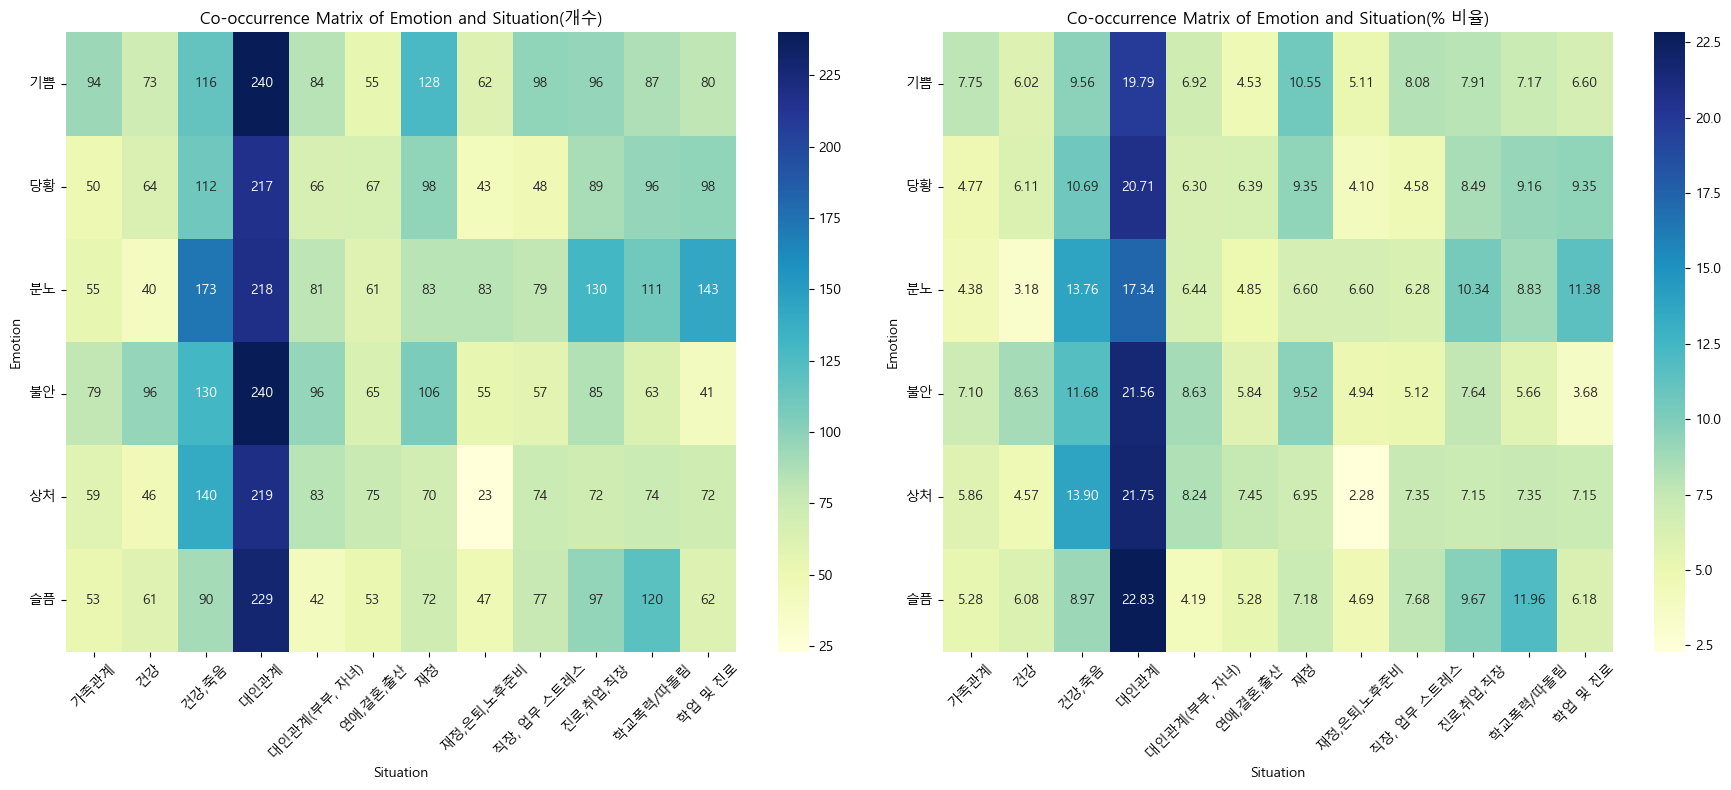

In [6]:
# '감정_대분류'와 '상황키워드'에 대한 co-occurrence matrix 계산
co_occurrence_matrix = pd.crosstab(df['감정_대분류'], df['상황키워드'])

# 각 셀의 값에 대해 해당 행의 총합으로 나눈 백분율을 계산합니다.
# (axis=1은 행을 기준으로 계산하도록 함)
co_occurrence_percent = co_occurrence_matrix.div(co_occurrence_matrix.sum(axis=1), axis=0) * 100

# 그래프로 나타내기 위해 Seaborn의 heatmap을 사용합니다.
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# 첫 번째 heatmap: co-occurrence matrix의 개수
sns.heatmap(co_occurrence_matrix, cmap="YlGnBu", annot=True, fmt="d", ax=axes[0])
axes[0].set_title("Co-occurrence Matrix of Emotion and Situation(개수)")
axes[0].set_xlabel("Situation")
axes[0].set_ylabel("Emotion")
axes[0].tick_params(axis='x', rotation=45)
axes[0].tick_params(axis='y', rotation=0)

# 두 번째 heatmap: co-occurrence matrix의 백분율 (반올림하여 소수점 두 자리까지 표시)
sns.heatmap(co_occurrence_percent, cmap="YlGnBu", annot=True, fmt=".2f", ax=axes[1])
axes[1].set_title("Co-occurrence Matrix of Emotion and Situation(% 비율)")
axes[1].set_xlabel("Situation")
axes[1].set_ylabel("Emotion")
axes[1].tick_params(axis='x', rotation=45)
axes[1].tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.show()

# 엑셀 파일로 저장
co_occurrence_matrix.to_excel('co_occurrence_matrix.xlsx')
co_occurrence_percent.to_excel('co_occurrence_percent.xlsx')